## Description

In [1]:
description = 0
if description:
    # We optionally write a description of the dataset to description.txt
    fn = open("description.txt", "w")
    fn.write("$Processed by = Mathew Chamberlain \n")
    fn.write("$Date = January 28, 2019 \n")
    fn.write("$Description = This is an example dataset processed by Mathew Chamberlain.\n")
    fn.close()

## Setup

In [2]:
# cellranger import
#import modules, define some functions for loading, saving and processing a gene-barcode matrix
%matplotlib inline
import pkg_resources
import collections
import numpy as np
import pandas as pd
import scipy.sparse as sp_sparse
import tables
import matplotlib
import matplotlib.pyplot as plt
import h5py

np.random.seed(0)

GeneBCMatrix = collections.namedtuple('GeneBCMatrix', ['gene_ids', 'gene_names', 'barcodes', 'matrix'])

def get_matrix_from_h5(filename, genome):
    with tables.open_file(filename, 'r') as f:
        try:
            dsets = {}
            for node in f.walk_nodes('/' + genome, 'Array'):
                dsets[node.name] = node.read()
            matrix = sp_sparse.csc_matrix((dsets['data'], dsets['indices'], dsets['indptr']), shape=dsets['shape'])
            return GeneBCMatrix(dsets['genes'], dsets['gene_names'], dsets['barcodes'], matrix)
        except tables.NoSuchNodeError:
            raise Exception("Genome %s does not exist in this file." % genome)
        except KeyError:
            raise Exception("File is missing one or more required datasets.")

def save_matrix_to_h5(gbm, filename, genome):
    flt = tables.Filters(complevel=1)
    with tables.open_file(filename, 'w', filters=flt) as f:
        try:
            group = f.create_group(f.root, genome)
            f.create_carray(group, 'genes', obj=gbm.gene_ids)
            f.create_carray(group, 'gene_names', obj=gbm.gene_names)
            f.create_carray(group, 'barcodes', obj=gbm.barcodes)
            f.create_carray(group, 'data', obj=gbm.matrix.data)
            f.create_carray(group, 'indices', obj=gbm.matrix.indices)
            f.create_carray(group, 'indptr', obj=gbm.matrix.indptr)
            f.create_carray(group, 'shape', obj=gbm.matrix.shape)
        except:
            raise Exception("Failed to write H5 file.")
        
def subsample_matrix(gbm, barcode_indices):
    return GeneBCMatrix(gbm.gene_ids, gbm.gene_names, gbm.barcodes[barcode_indices], gbm.matrix[:, barcode_indices])

def get_expression(gbm, gene_name):
    gene_indices = np.where(gbm.gene_names == gene_name)[0]
    if len(gene_indices) == 0:
        raise Exception("%s was not found in list of gene names." % gene_name)
    return gbm.matrix[gene_indices[0], :].toarray().squeeze()

def save_count_matrix_to_h5(E, gene_list, filename):
    with h5py.File(filename, 'w') as hf:
        hf.create_dataset("indptr" ,  data= E.indptr)
        hf.create_dataset("indices",  data= E.indices)
        hf.create_dataset("data"   ,  data= E.data)
        hf.create_dataset("shape"  ,  data= E.shape)
        hf.create_dataset("genes"  ,  data= gene_list)

In [3]:
%pylab inline
from helper_functions import *
#from doublet_detector import *
from collections import defaultdict

Populating the interactive namespace from numpy and matplotlib


In [4]:
#plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'DejaVu Sans'
plt.rc('font', size=14)
plt.rcParams['pdf.fonttype'] = 42

## Load data

In [5]:
sample_list = !ls rawdata

In [6]:
# D stores all the data; one entry per library
D = {}

for j, s in enumerate(sample_list):   
    filtered_matrix_h5 = "rawdata/"+s+"/count_matrix.h5"
    print filtered_matrix_h5
    genome = "GRCh38"
    D[s] = {}
    D[s]['meta'] = {}
    gbm = get_matrix_from_h5(filtered_matrix_h5, genome)
    D[s]['E'] = transpose(gbm.matrix)
    D[s]['meta']['gene_list']=gbm.gene_names
    D[s]['meta']['gene_id']=gbm.gene_ids
    print D[s]['E'].shape
    D[s]['cell_index']=gbm.barcodes
    print (len(D[s]['cell_index']))

rawdata/300-0122/count_matrix.h5
(371, 29420)
371
rawdata/300-0153/count_matrix.h5
(190, 29420)
190
rawdata/300-0211/count_matrix.h5
(282, 29420)
282
rawdata/300-0213/count_matrix.h5
(277, 29420)
277
rawdata/300-0481/count_matrix.h5
(191, 29420)
191
rawdata/300-0482/count_matrix.h5
(561, 29420)
561
rawdata/300-0483/count_matrix.h5
(192, 29420)
192
rawdata/300-0485/count_matrix.h5
(572, 29420)
572
rawdata/300-0486/count_matrix.h5
(548, 29420)
548
rawdata/300-0487/count_matrix.h5
(570, 29420)
570
rawdata/300-0511/count_matrix.h5
(946, 29420)
946
rawdata/300-0528/count_matrix.h5
(558, 29420)
558
rawdata/300-0546/count_matrix.h5
(571, 29420)
571
rawdata/300-2590/count_matrix.h5
(430, 29420)
430
rawdata/301-0121/count_matrix.h5
(236, 29420)
236
rawdata/301-0122/count_matrix.h5
(336, 29420)
336
rawdata/301-0132/count_matrix.h5
(547, 29420)
547
rawdata/301-0151/count_matrix.h5
(331, 29420)
331
rawdata/301-0153/count_matrix.h5
(48, 29420)
48
rawdata/301-0155/count_matrix.h5
(285, 29420)
285
ra

In [7]:
gene_list = D[s]['meta']['gene_list']
gene_id = D[s]['meta']['gene_id']

## Filter cells by total counts and number of genes detected


/usr/local/lib/python2.7/dist-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


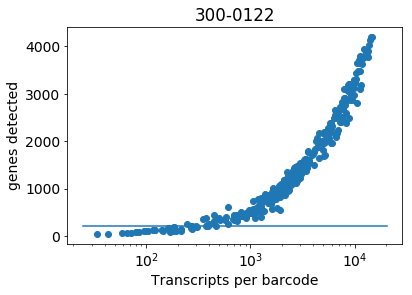

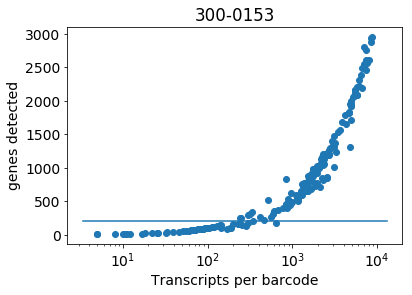

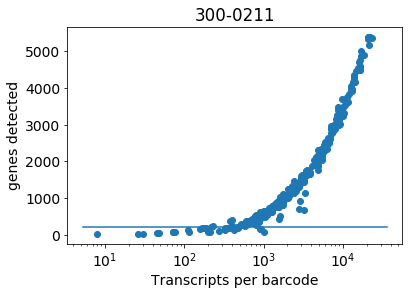

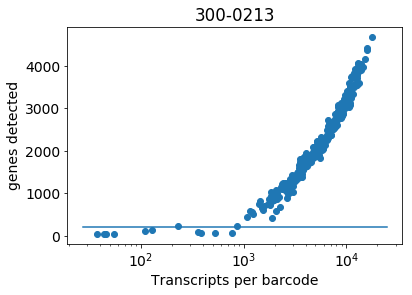

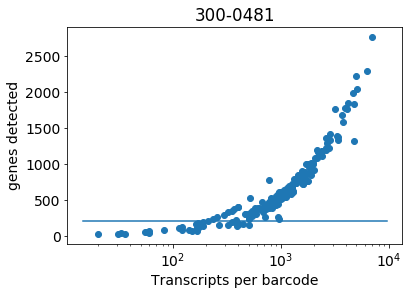

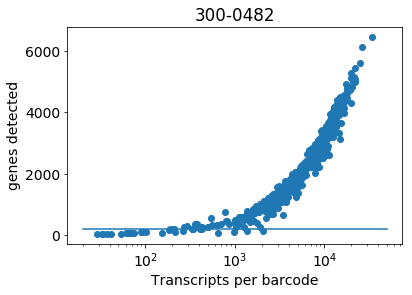

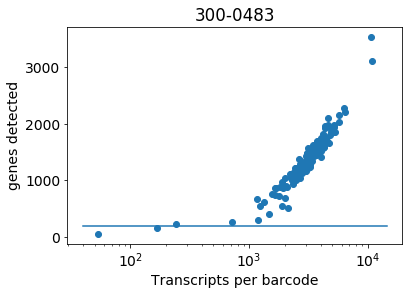

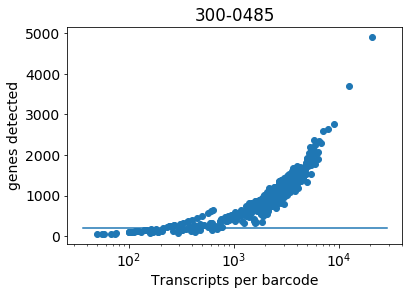

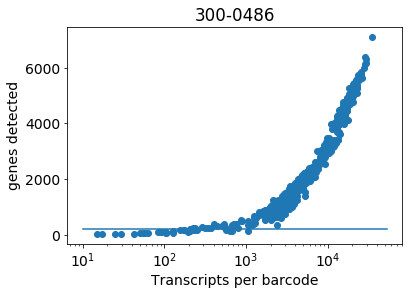

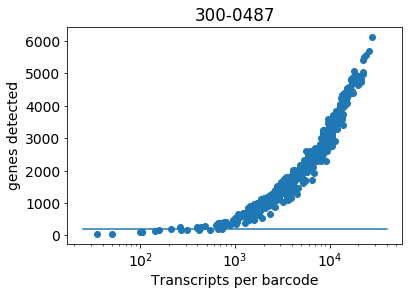

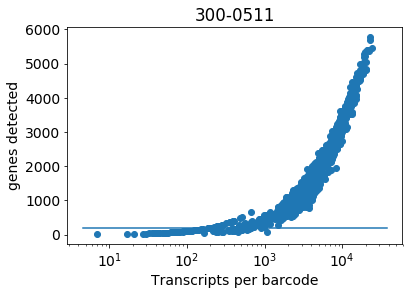

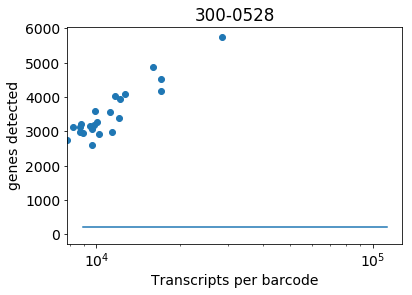

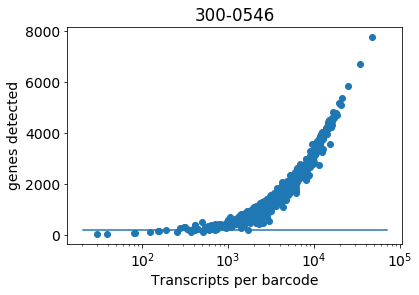

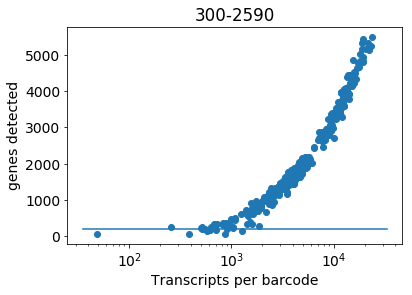

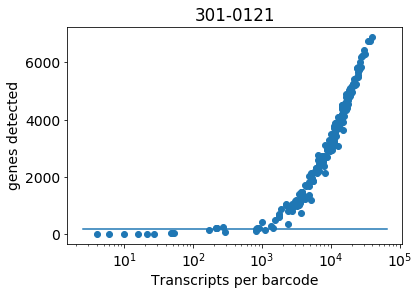

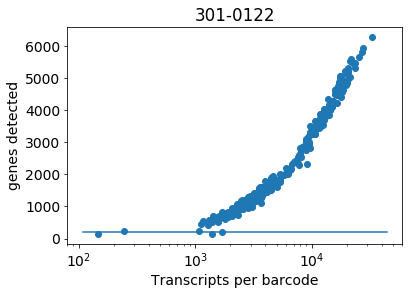

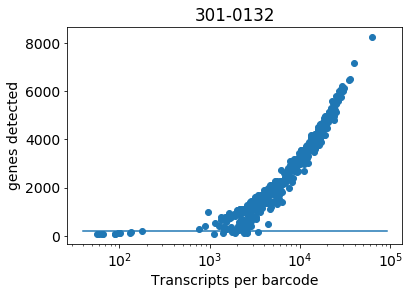

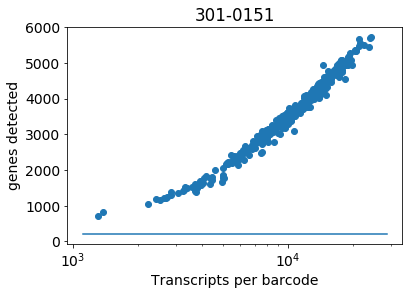

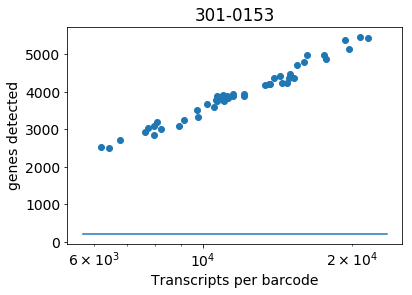

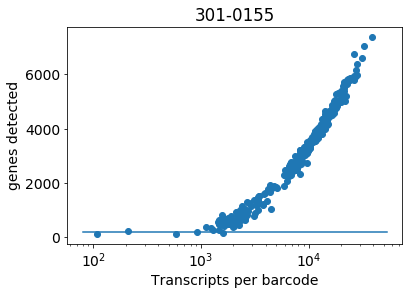

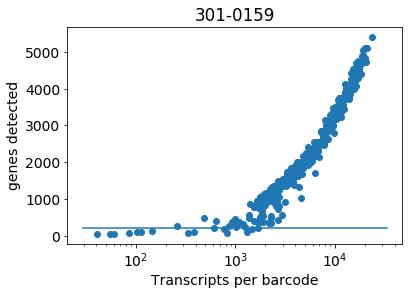

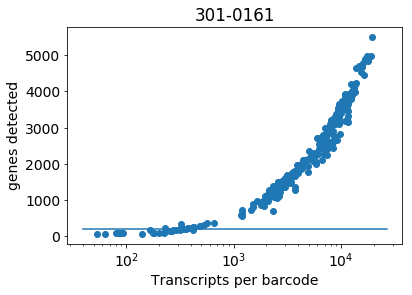

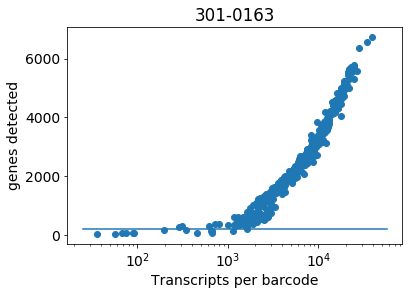

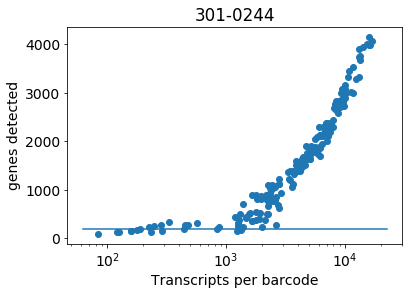

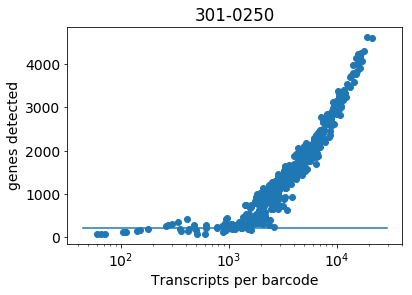

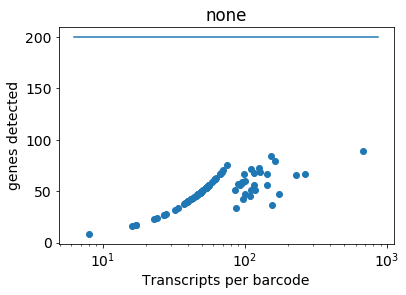

In [8]:
# plot total counts histograms - don't actually filter out any barcodes yet


# adjust total counts thresholds

for j,s in enumerate(sample_list):
    D[s]['total_counts'] = np.sum(D[s]['E'], axis=1).A[:,0]
    D[s]['genes_detected'] = np.sum(D[s]['E']>0, axis=1).A[:,0]
    D[s]['meta']['min_tot']= np.mean(D[s]['total_counts'])+np.std(D[s]['total_counts'])
    D[s]['meta']['min_genes_detected']=200;
    if 0:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.hist(D[s]['total_counts'], bins=np.logspace(0, 6, 50))
        ax.set_xscale('log')
        ax.set_xlabel('Transcripts per barcode')
        ax.set_ylabel('Number of barcodes')

        ax.plot([D[s]['meta']['min_tot'],D[s]['meta']['min_tot']],ax.get_ylim());
        title(s)

        fig2 = plt.figure()
        ax2 = fig2.add_subplot(111)
        ax2.set_xscale('log')
        ax2.set_xlabel('Genes per barcode ')
        ax2.set_ylabel('Number of barcodes')
        ax2.hist(D[s]['genes_detected'], bins=np.logspace(0, 6, 50))


    fig3 = plt.figure()
    ax3 = fig3.add_subplot(111)
    ax3.set_xscale('log')
    ax3.set_xlabel('Transcripts per barcode')
    ax3.set_ylabel('genes detected')

    ax3.scatter(D[s]['total_counts'],D[s]['genes_detected']);
    ax3.plot(ax3.get_xlim(),[D[s]['meta']['min_genes_detected'],D[s]['meta']['min_genes_detected']]);
    title(s)
    
    

In [9]:
D_orig=D
for j,s in enumerate(sample_list):
    ix = D[s]['genes_detected'] > 200
    print D_orig[s]['E'].shape[0]
    if np.sum(ix) > 0:
        print s, np.sum(ix), '/', D[s]['E'].shape[0], np.median(D[s]['total_counts'][ix]), np.mean(D[s]['total_counts'][ix])


371
300-0122 339 / 371 2794.0 4105.315634218289
190
300-0153 131 / 190 2218.0 2882.5648854961833
282
300-0211 254 / 282 3693.0 5313.858267716535
277
300-0213 267 / 277 5643.0 6412.397003745318
191
300-0481 158 / 191 1097.5 1510.993670886076
561
300-0482 535 / 561 4651.0 6443.867289719627
192
300-0483 190 / 192 3265.5 3352.1631578947367
572
300-0485 523 / 572 2194.0 2541.940726577438
548
300-0486 519 / 548 4520.0 7576.907514450867
570
300-0487 558 / 570 3939.0 6186.896057347671
946
300-0511 855 / 946 4312.0 5610.001169590643
558
300-0528 417 / 558 2883.0 3439.896882494005
571
300-0546 558 / 571 3526.5 5338.069892473119
430
300-2590 421 / 430 4128.0 6315.266033254156
236
301-0121 222 / 236 11096.0 11734.382882882883
336
301-0122 333 / 336 4175.0 7482.591591591591
547
301-0132 527 / 547 4453.0 7892.341555977229
331
301-0151 331 / 331 10577.0 10991.114803625378
48
301-0153 48 / 48 11360.5 12358.916666666666
285
301-0155 281 / 285 9471.0 10418.540925266903
376
301-0159 363 / 376 4085.0 6396

In [10]:
# Actually filter out low-count barcodes
for j,s in enumerate(sample_list):
    print '---  %s ---' %s
    print 'Pre-filter: %i barcodes' %D[s]['E'].shape[0]
    tmpfilt = np.nonzero(D[s]['genes_detected'] > 200)[0]
    print max(tmpfilt)
    print D[s]['E'].shape
    D[s] = filter_dict(D[s], tmpfilt)
    print 'Post-filter: %i barcodes' %D[s]['E'].shape[0]
    print D[s]['E'].shape

---  300-0122 ---
Pre-filter: 371 barcodes
370
(371, 29420)
Post-filter: 339 barcodes
(339, 29420)
---  300-0153 ---
Pre-filter: 190 barcodes
187
(190, 29420)
Post-filter: 131 barcodes
(131, 29420)
---  300-0211 ---
Pre-filter: 282 barcodes
281
(282, 29420)
Post-filter: 254 barcodes
(254, 29420)
---  300-0213 ---
Pre-filter: 277 barcodes
276
(277, 29420)
Post-filter: 267 barcodes
(267, 29420)
---  300-0481 ---
Pre-filter: 191 barcodes
189
(191, 29420)
Post-filter: 158 barcodes
(158, 29420)
---  300-0482 ---
Pre-filter: 561 barcodes
560
(561, 29420)
Post-filter: 535 barcodes
(535, 29420)
---  300-0483 ---
Pre-filter: 192 barcodes
191
(192, 29420)
Post-filter: 190 barcodes
(190, 29420)
---  300-0485 ---
Pre-filter: 572 barcodes
571
(572, 29420)
Post-filter: 523 barcodes
(523, 29420)
---  300-0486 ---
Pre-filter: 548 barcodes
547
(548, 29420)
Post-filter: 519 barcodes
(519, 29420)
---  300-0487 ---
Pre-filter: 570 barcodes
569
(570, 29420)
Post-filter: 558 barcodes
(558, 29420)
---  300-0

ValueError: max() arg is an empty sequence

## Filter cells by mito fraction

In [11]:
# get mitochondrial genes

mt_ix = [i for i,g in enumerate(gene_list) if g.startswith('MT-')]
print [gene_list[i] for i in mt_ix]

['MT-ATP6', 'MT-ATP8', 'MT-CO1', 'MT-CO2', 'MT-CO3', 'MT-CYB', 'MT-ND1', 'MT-ND2', 'MT-ND3', 'MT-ND4', 'MT-ND4L', 'MT-ND5', 'MT-ND6', 'MT-RNR1', 'MT-RNR2', 'MT-TA', 'MT-TC', 'MT-TD', 'MT-TE', 'MT-TF', 'MT-TG', 'MT-TH', 'MT-TI', 'MT-TL1', 'MT-TL2', 'MT-TM', 'MT-TP', 'MT-TQ', 'MT-TS2', 'MT-TT', 'MT-TW', 'MT-TY']


300-0122
(339, 29420)
[ 1261.  5911.   349.  2416.  2694.  1697.  1476.  1251.  1340.   811.
  2820.  2429.  1754.  2675.  2698.  2134.  6892.  2101.  3159.  1179.
  1365.  6656. 13521.  2236.  1915.  2103.  1904.  2794.  1940.  2874.
  1889.  2096.  1489.  4074.  3461.  1259.  2920.  2595.  3308.  1739.
  1543.  2974.  2374.  2677.  3246.  2212.   579.   511.  3268.  1752.
  2530.   277.  1062. 12388.  2129.   737.  2021.   906.  3080.  1206.
  1697.   806.  3500.  1194.   702.  1643.  1568.  5813.  7494.  9377.
  8967.  5694. 11303.  1532.  7525.  5167.  7919.  5858.  8009.  8632.
  4932. 13947.  8309.  3559. 11212.  9204. 12386. 12074.  5861. 10263.
  1395.  1498.  1507.  3010.  1508.  3623.  2188.  2685.  2642.  2849.
   609.  3500.  1806.  9362.  9900.  1332.  2662.  4257.  2597.  1276.
  2311.  2173.  3020.  2693.  1166.  1956.  3181.  1505.  2087.  7053.
  1595.  4644.  3146.  1123.  1171.  2384.  4517.  2293.  3158.  2873.
  2814.  1636.  2720.  2161.   245.   608.   693.  2724

[ 1252.   246.  1207.  1679.  1762.  2498.  1597.  1525.  1082.   943.
  2273.  1131.  1994.  2531.  1699.  1532.  1416.   210.  4574.  1448.
  3853.  4567.  4927.  1387.  1451.  3029.  2662.  1856.   610.  3274.
  2128.  1667.  1079.  1944.  2183.  1418.   487.  1997.  2947.  2155.
  2826.  2062.  2175.  1978.  2717.  2077.  2386.  1812.  2414.  2425.
  2445.   937.  1618.  2159.  1983.  2256.  3163.  2358.  1576.  1634.
  2058.  2492.  2690.  1412.  1294.  2722.  1534.  2916.  2704.  1722.
  1397.  1975.  7017.  3023.  3982.  4711.  4027.  1414.   797.  1737.
  2408.   735.  3757.  1034.   415.   415.  5577.  5028.  2080.   881.
  2147.  1700.  1661.  1312.  3115.  1496.  1314.  3031.  1156.  1616.
  1615.  2176.  6321.  2131.  4855.  1327.   966.  2326.  2050.   567.
  2113.  1818.  1395.  2961.  2317.  2935.  3856.  5403.  1550.  1433.
   956.   442.  5114.  1533.  1534.  2295.  2241.  1952.  1044.  2156.
  1336.  1740.  2688.   518.  2598.  3344.  1573.  2919.  1573.  2608.
  2259

417 385
300-0546
(558, 29420)
[ 3756.  6123.  5183.  3151.  5800.  2869.  4316.  2923.  6049.  4416.
  3062.  6502.  6867.  2319.  4487.  8285.  9673.  3683.  4357.  6106.
  4633.  2413.  1803.  1961.  5742.  2957.  8853.  5423.  5247.  1244.
  5938.  2321.  2692.  4898.  4640.   862.  1974.  3062.  5966.  1906.
  2912.  4723.   274.  3157.  1881.  1319.  3036.   415.  4160.  4136.
  2851.  2734.  9961.  2955.  3271.  2515.  2558.  3699.  1684.  5876.
  8181.  3437.  7509.  4459.  3939.  4254.  3113. 11317.  3993.  3661.
  7604.  6313.  4072.  1398.  5325. 15304.  4523.  5431.  2512.  7759.
  4054.  2652.  2068.  1551.  1469.  3954.  4096.  2137.  3997.  3841.
  2290.  1959.  4521.  3764.   592.  3462.  6158.  5849.  3864.  2614.
  3013.  3316.   319.  2164.  7334.  1070.  2470.  1579.  1578.  3292.
  2374.  5008.  4660.  6103.  3827.  8426.  6626.  3244. 12414.  8239.
  5944.  3251.  2543.  9061.  4635.  2099.  5122.  2685.  2428.  2362.
  3479.  1038.  8295.   439.  3383.  5501.  239

527 493
301-0151
(331, 29420)
[ 7185.  9915.  8430.  7067.  8934. 12219. 12368.  7349.  6606. 12237.
  8665.  8949.  3562.  6785.  9160. 12700. 10364. 10065.  5268.  7541.
  3771.  3690. 11058. 14977.  6641.  4566.  7571.  4349.  9089.  5871.
  7021.  9212. 14499.  8191.  8042.  5467. 13100. 10192.  7457. 14918.
 10652. 13272.  9143. 14460. 21409. 15898. 18987. 11666. 15142. 17754.
 14473. 17203. 17380. 17675. 14415. 14172. 16636. 17312. 14162. 13191.
  7390. 22581.  5007. 14641. 16971. 14517.  3919. 19425. 12798. 15114.
 23855. 11586. 15352.  5518. 11684. 10500. 19088.  4016. 10972.  9929.
 20528. 16550. 12427. 10388. 12134.  7494.  5972.  8479.  6416. 10627.
  3270.  7133.  9609.  9941.  7535.  8014.  6318.  5163.  7625. 10007.
  6130.  4136.  5413.  7132.  6919.  2862.  5280.  9520.  7297.  9849.
  7917. 10009. 12899.  6253.  8454.  7385. 11894. 10577.  7501.  8124.
 12109.  7394. 11971. 20744. 13707. 13133. 17184. 15320. 10303. 17266.
  9342. 19208.  3889. 12631.  9209. 17123. 1641

301-0163
(447, 29420)
[ 2785.  2725.  3615.  2666.  1321.  3836.  3690.  2495.  2822.  1623.
  3458.  1295.  2802.  2344.  3748.  2609.  2067.  4218.  5217.  3233.
  2740.  2719.  2887.  4052.  3614.  3241.  4018.  2994.  3066.  3037.
  3163.  3282.  2167.  2962.  3430.  5584.  8900. 15267. 10884.  4991.
 14282.  1325.  1524.  1721.  7344.  1666.  2199.  5082. 10147.  2565.
  6183.  2406.  5521.  7304.  1177.  4239.  7859.  5204.  2522.  6178.
 17684.  1202.  6657.  7048.  3180.  4726.  1358. 14042. 12672. 12630.
  7771. 10762.  9721. 11875. 13002. 11010. 11460.  3549.  4819.  5127.
 13920. 10849.  7466.  5826. 12422.  6877. 10258. 15065. 11758.  2730.
  4387.  3874.  2156.  2546.  2529.  4062.  5908.  3672.  3014.  3751.
  4293.  4137.  4166.  3229.  4004.  2700.  2900.   725.  4293.  3902.
  1223.  2644.  4091.  1484.  3296.  2833.  1768.  3820.  4204.  7917.
   286.  6608.   794. 10386.  4037. 15301. 11640.  9965. 11851.  8770.
  4311.  2686.  2985. 12731.  8283.  6840. 12948.  2897

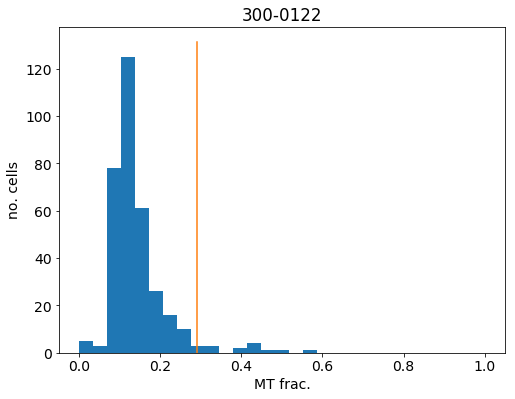

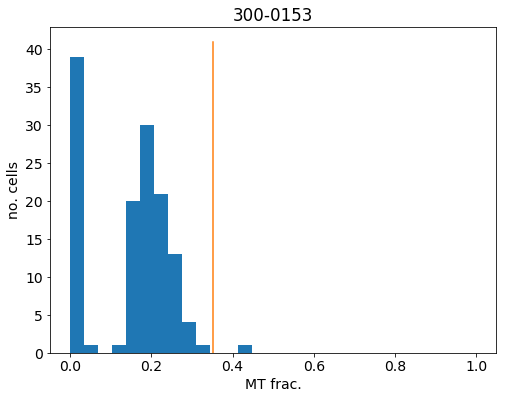

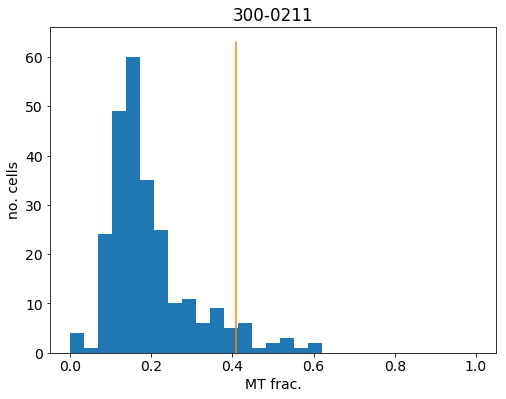

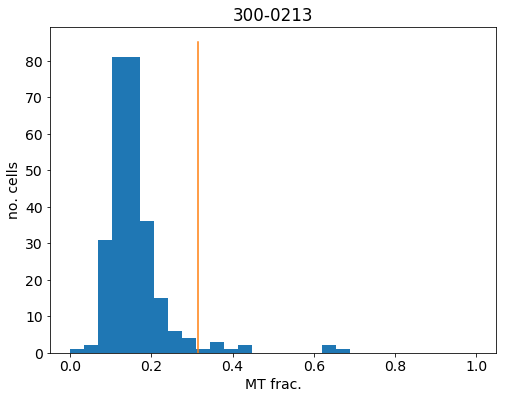

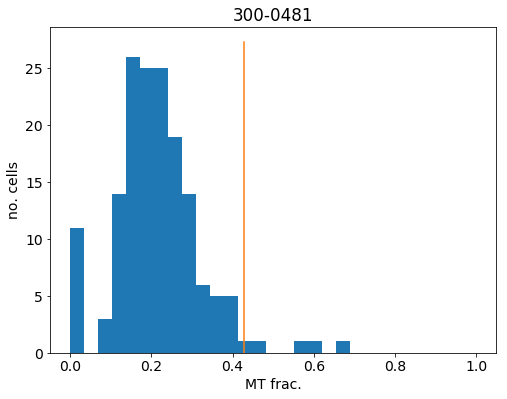

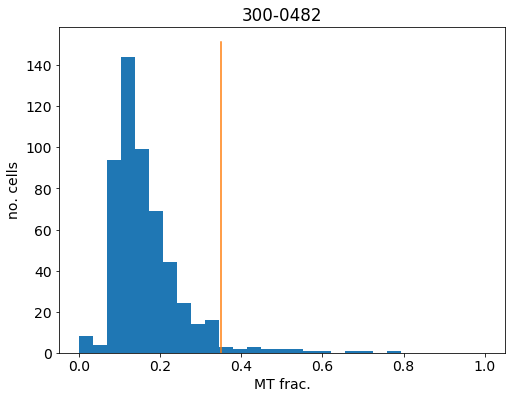

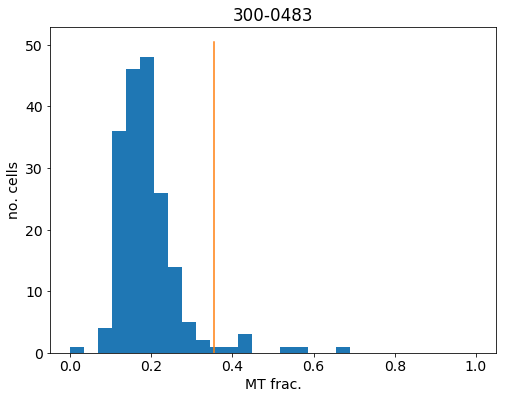

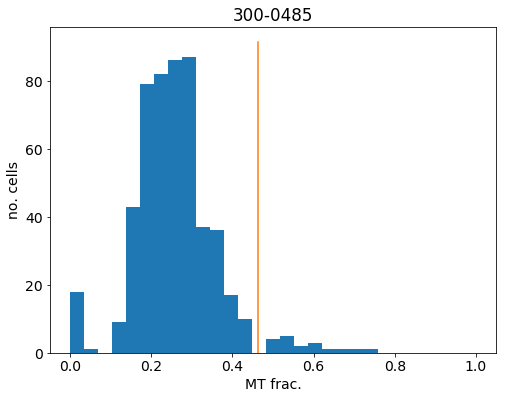

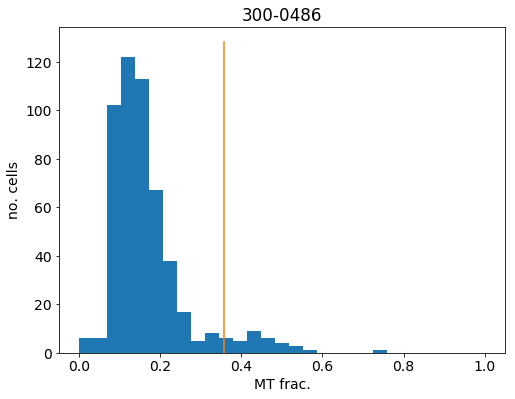

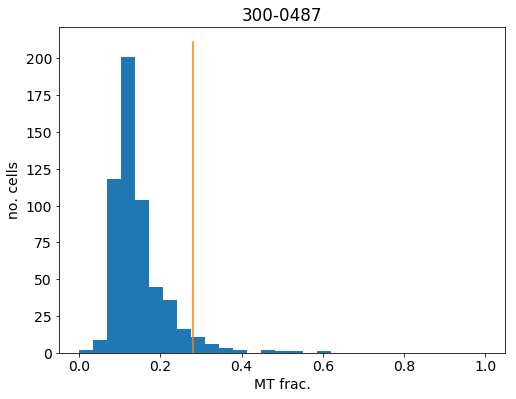

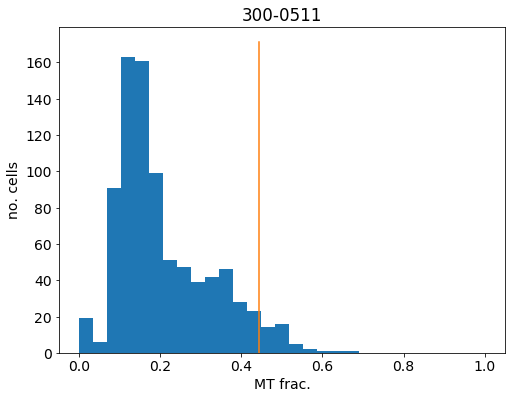

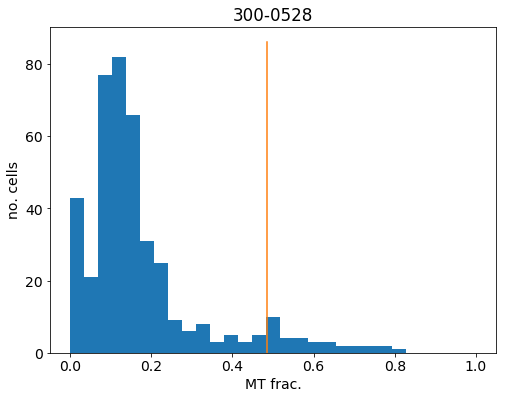

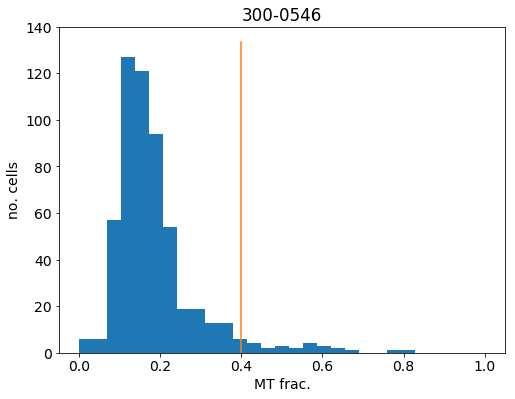

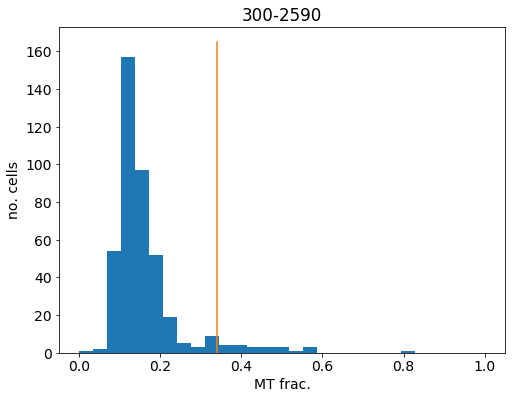

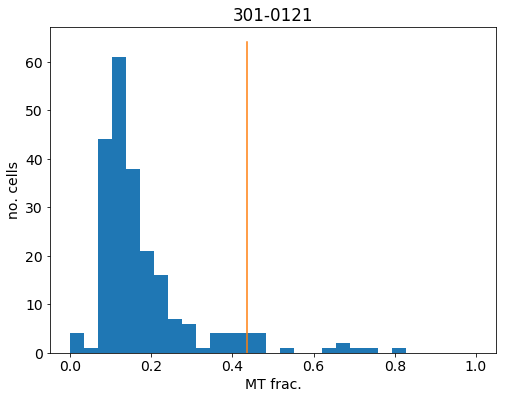

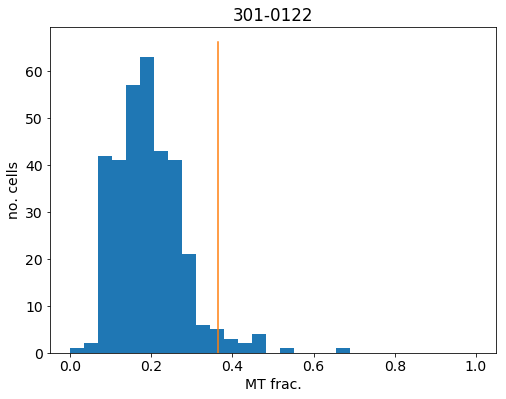

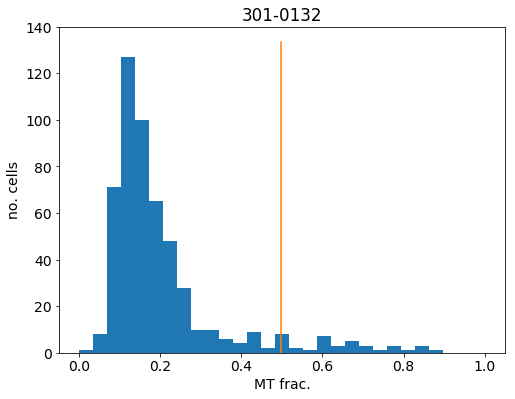

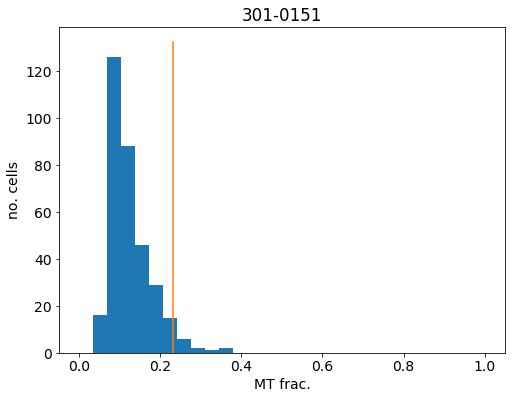

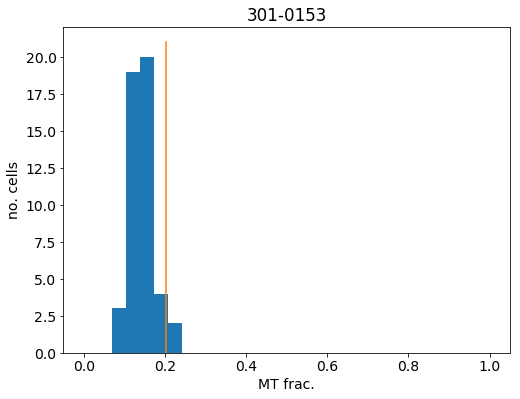

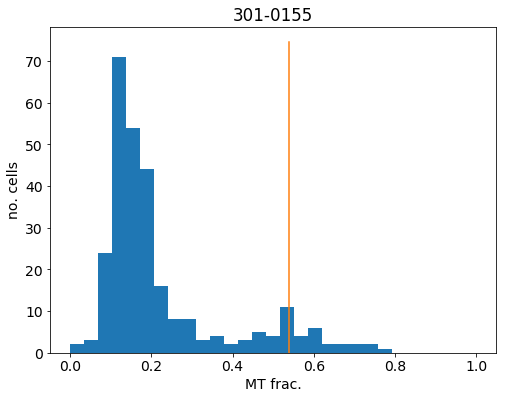

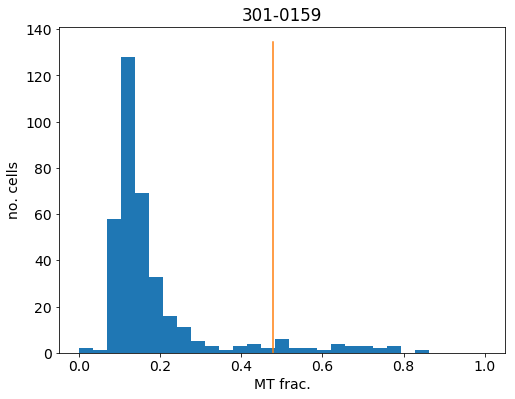

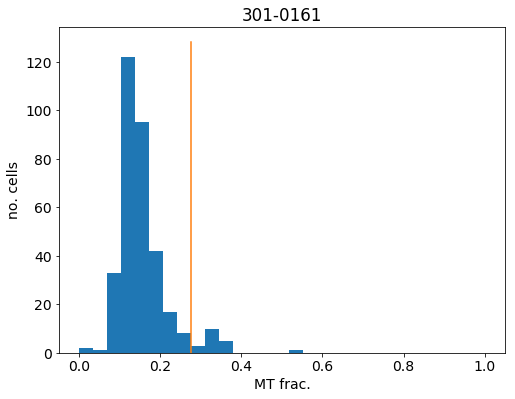

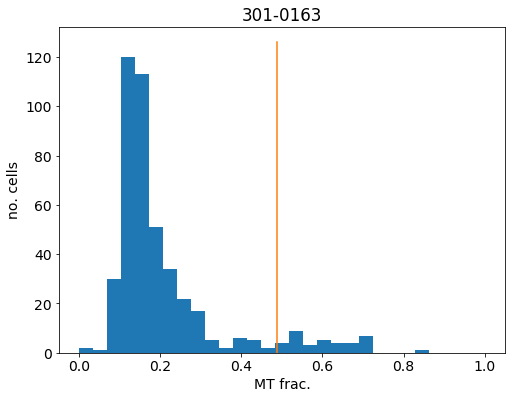

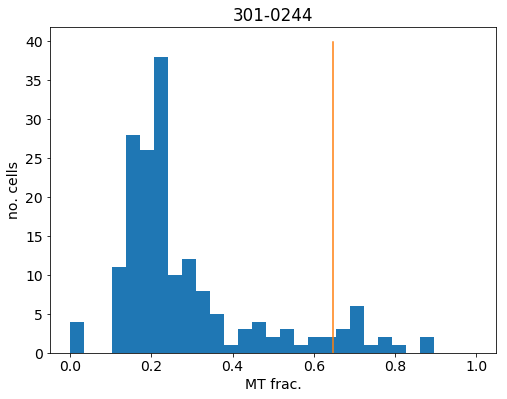

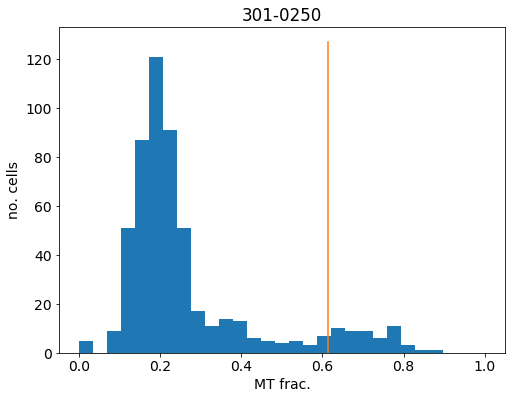

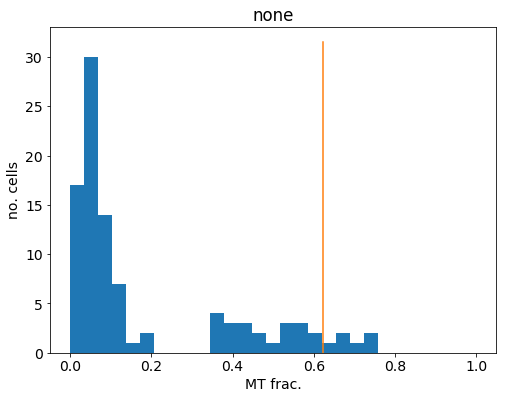

In [12]:
# plot mito-gene frac histograms - don't actually filter out any cells yet

# set mito-gene frac threshold
for j,s in enumerate(sample_list):
    D[s]['meta']['max_mt'] = 0.1

for j,s in enumerate(sample_list):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, xscale='linear', yscale='linear',
        xlabel='MT frac.', ylabel='no. cells')
    print s
    print D[s]['E'].shape
    print np.sum(D[s]['E'], axis=1,dtype=float).A[:,0]

    D[s]['mito_frac'] = np.sum(D[s]['E'][:,mt_ix], axis=1).A[:,0] / np.sum(D[s]['E'], axis=1,dtype=float).A[:,0]
    D[s]['meta']['max_mt'] = np.mean(D[s]['mito_frac'])+ 2 * np.std(D[s]['mito_frac'])
    print D[s]['meta']['max_mt']
    ax.hist(D[s]['mito_frac'], cumulative=False, 
            bins=np.linspace(0, 1, 30))

    ax.plot([D[s]['meta']['max_mt'],D[s]['meta']['max_mt']],ax.get_ylim());
    title(s)

    print D[s]['E'].shape[0], np.sum(D[s]['mito_frac'] <= D[s]['meta']['max_mt'])


In [13]:
# Actually filter out mito-high cells 
D_filt=D
for s in sample_list:
    print '---  %s ---' %s
    print 'Pre-filter: %i barcodes' %D[s]['E'].shape[0]
    tmpfilt = np.nonzero(D[s]['mito_frac'] <= D[s]['meta']['max_mt'])[0]
    D[s] = filter_dict(D[s], tmpfilt)
    print 'Post-filter: %i barcodes' %D[s]['E'].shape[0]
    
#del tmpfilt

---  300-0122 ---
Pre-filter: 339 barcodes
Post-filter: 324 barcodes
---  300-0153 ---
Pre-filter: 131 barcodes
Post-filter: 130 barcodes
---  300-0211 ---
Pre-filter: 254 barcodes
Post-filter: 239 barcodes
---  300-0213 ---
Pre-filter: 267 barcodes
Post-filter: 258 barcodes
---  300-0481 ---
Pre-filter: 158 barcodes
Post-filter: 154 barcodes
---  300-0482 ---
Pre-filter: 535 barcodes
Post-filter: 516 barcodes
---  300-0483 ---
Pre-filter: 190 barcodes
Post-filter: 182 barcodes
---  300-0485 ---
Pre-filter: 523 barcodes
Post-filter: 505 barcodes
---  300-0486 ---
Pre-filter: 519 barcodes
Post-filter: 485 barcodes
---  300-0487 ---
Pre-filter: 558 barcodes
Post-filter: 536 barcodes
---  300-0511 ---
Pre-filter: 855 barcodes
Post-filter: 814 barcodes
---  300-0528 ---
Pre-filter: 417 barcodes
Post-filter: 385 barcodes
---  300-0546 ---
Pre-filter: 558 barcodes
Post-filter: 534 barcodes
---  300-2590 ---
Pre-filter: 421 barcodes
Post-filter: 397 barcodes
---  301-0121 ---
Pre-filter: 222 

## Merge data, normalize

In [14]:
# create master dataset (all SPRING subsets will refer back to this)

samp_lookup = {}
samp_id_flat = np.array([],dtype=str)

for s in D.keys():
    samp_id_flat = np.append(samp_id_flat, [s] * D[s]['E'].shape[0])

        
E = scipy.sparse.lil_matrix((len(samp_id_flat), len(gene_list)), dtype=int)
total_counts = np.zeros(len(samp_id_flat), dtype=int)
mito_frac = np.zeros(len(samp_id_flat), dtype=float)
genes_detected = np.zeros(len(samp_id_flat), dtype=int)

for s in D.keys():
    print s
    E[samp_id_flat == s, :] = D[s]['E']
    total_counts[samp_id_flat == s] = D[s]['total_counts']
    mito_frac[samp_id_flat == s] = D[s]['mito_frac']
    genes_detected[samp_id_flat == s] = D[s]['genes_detected']

E = E.tocsc()

300-0122
300-0511
300-0211
300-0213
301-0244
300-0546
301-0121
301-0122
301-0161
301-0163
300-0528
300-0153
300-0481
300-0482
300-0483
300-0485
300-0486
300-0487
none
300-2590
301-0159
301-0250
301-0151
301-0153
301-0155
301-0132


In [15]:
E_full=E

In [16]:
# remove genes that are not expressed by any cells
# optionally remove mito and rps genes
gene_list = D[sample_list[1]]['meta']['gene_list']
gene_id = D[sample_list[1]]['meta']['gene_id']
remove_crapgenes = 1

if remove_crapgenes:
    import re
    mt_ix = [i for i,g in enumerate(gene_list) if g.startswith('MT-')]
    print [gene_list[i] for i in mt_ix]
    #rp_ix = [i for i,g in enumerate(gene_list) if g.startswith('RPS') or g.startswith('RPL')]
    #rp_ix = [i for i,g in enumerate(gene_list) if g.startswith('RPS','RPL')]
    rp_ix = [i for i,g in enumerate(gene_list) if g.startswith('RP1') 
             or g.startswith('RP2') or g.startswith('RP3')
             or g.startswith('RP4') or g.startswith('RP5')
             or g.startswith('RP6') or g.startswith('RP7')
             or g.startswith('RP8') or g.startswith('RP9')
             or g.startswith('RPL') or g.startswith('RPS')
            ]
    #or g.startswith('RP4','RP5','RP6') or g.startswith('RP7','RP8','RP9')]
    print [gene_list[i] for i in rp_ix]  
    keep_genes = (E.sum(0) > 0).A.squeeze() #* rp_ix * mt_ix
    print sum(keep_genes), '/', len(keep_genes)
    keep_genes[rp_ix] = 0
    print sum(keep_genes), '/', len(keep_genes)
    keep_genes[mt_ix] = 0
    print sum(keep_genes), '/', len(keep_genes)
else:
    keep_genes = (E.sum(0) > 0).A.squeeze()
    print sum(keep_genes), '/', len(keep_genes)


['MT-ATP6', 'MT-ATP8', 'MT-CO1', 'MT-CO2', 'MT-CO3', 'MT-CYB', 'MT-ND1', 'MT-ND2', 'MT-ND3', 'MT-ND4', 'MT-ND4L', 'MT-ND5', 'MT-ND6', 'MT-RNR1', 'MT-RNR2', 'MT-TA', 'MT-TC', 'MT-TD', 'MT-TE', 'MT-TF', 'MT-TG', 'MT-TH', 'MT-TI', 'MT-TL1', 'MT-TL2', 'MT-TM', 'MT-TP', 'MT-TQ', 'MT-TS2', 'MT-TT', 'MT-TW', 'MT-TY']
['RP1', 'RP1-100J12.1', 'RP1-101K10.6', 'RP1-102D24.5', 'RP1-102E24.8', 'RP1-102G20.5', 'RP1-102H19.8', 'RP1-102K2.6', 'RP1-104O17.2', 'RP1-105O18.1', 'RP1-111B22.3', 'RP1-111C20.4', 'RP1-111D6.3', 'RP1-118J21.25', 'RP1-120G22.11', 'RP1-121G13.2', 'RP1-122K4.3', 'RP1-122O8.7', 'RP1-122P22.2', 'RP1-124C6.1', 'RP1-125I3.2', 'RP1-127C7.6', 'RP1-127D3.4', 'RP1-128O3.4', 'RP1-12G14.6', 'RP1-12G14.7', 'RP1-130H16.16', 'RP1-134E15.3', 'RP1-135L22.1', 'RP1-136B1.1', 'RP1-137D17.1', 'RP1-137D17.2', 'RP1-137K2.2', 'RP1-137K24.1', 'RP1-138B7.5', 'RP1-13P20.6', 'RP1-140A9.1', 'RP1-140C12.2', 'RP1-140J1.1', 'RP1-140K8.5', 'RP1-142L7.5', 'RP1-142L7.8', 'RP1-142L7.9', 'RP1-144F13.3', 'RP1-146A1

In [17]:
# normalize by total counts
E = E[:,keep_genes]
E = tot_counts_norm_sparse(E)[0]

In [18]:
print shape(E)
gene_list = gene_list[keep_genes]
gene_id = gene_id[keep_genes]
# merged_list=[x+"_"+gene_id[i] for i,x in enumerate(gene_list)]
merged_list=gene_id

(8920, 23257)


## Save base directory files

In [19]:
# Set path for saving data -- you'll have to change this for your own setup.
# This path should be a subdirectory of your local copy of SPRING,
# specifically, {path_to_SPRING}/data/client_datasets/{main_dataset_name}. 
# See example below, where springViewer_1_6_dev.html is located in ../

main_spring_dir = '/cloud-data/ngstraining/CHAMBERLAIN.Mat/manuscripts/SPRING_dev-master/Data/AMP_Phase1_RA/'

if not os.path.exists(main_spring_dir):
    os.makedirs(main_spring_dir)

In [20]:
# if BCR data
BCR = 1

if BCR:
    barcode_dir = main_spring_dir + "barcodes/"
    if not os.path.exists(barcode_dir):
        os.makedirs(barcode_dir)
        for s in sample_list:
            print '---  %s ---' %s
            np.savetxt(barcode_dir + s, D[s]['cell_index'], fmt='%s')


---  300-0122 ---
---  300-0153 ---
---  300-0211 ---
---  300-0213 ---
---  300-0481 ---
---  300-0482 ---
---  300-0483 ---
---  300-0485 ---
---  300-0486 ---
---  300-0487 ---
---  300-0511 ---
---  300-0528 ---
---  300-0546 ---
---  300-2590 ---
---  301-0121 ---
---  301-0122 ---
---  301-0132 ---
---  301-0151 ---
---  301-0153 ---
---  301-0155 ---
---  301-0159 ---
---  301-0161 ---
---  301-0163 ---
---  301-0244 ---
---  301-0250 ---
---  none ---


In [21]:
MT = 1

if MT:
    MT_dir = main_spring_dir + "mito/"
    if not os.path.exists(MT_dir):
        os.makedirs(MT_dir)
        for s in sample_list:
            print '---  %s ---' %s
            np.savetxt(MT_dir + s, D[s]['mito_frac'], fmt='%s')

---  300-0122 ---
---  300-0153 ---
---  300-0211 ---
---  300-0213 ---
---  300-0481 ---
---  300-0482 ---
---  300-0483 ---
---  300-0485 ---
---  300-0486 ---
---  300-0487 ---
---  300-0511 ---
---  300-0528 ---
---  300-0546 ---
---  300-2590 ---
---  301-0121 ---
---  301-0122 ---
---  301-0132 ---
---  301-0151 ---
---  301-0153 ---
---  301-0155 ---
---  301-0159 ---
---  301-0161 ---
---  301-0163 ---
---  301-0244 ---
---  301-0250 ---
---  none ---


In [22]:
gene_list_new=np.array(merged_list)
np.savetxt(main_spring_dir + 'genes.txt', merged_list, fmt='%s')
scipy.io.mmwrite(main_spring_dir + 'matrix.mtx', E)

In [23]:
# save master expression matrix in hdf5 format
import h5py

print 'Saving hdf5 file for fast gene loading...'
E = E.tocsc()
hf = h5py.File(main_spring_dir + 'counts_norm_sparse_genes.hdf5', 'w')
counts_group = hf.create_group('counts')
cix_group = hf.create_group('cell_ix')

hf.attrs['ncells'] = E.shape[0]
hf.attrs['ngenes'] = E.shape[1]

for iG, g in enumerate(merged_list):
    if iG % 3000 == 0:
        print g, iG, '/', len(merged_list)
    counts = E[:,iG].A.squeeze()
    cell_ix = np.nonzero(counts)[0]
    counts = counts[cell_ix]
    counts_group.create_dataset(g, data = counts)
    cix_group.create_dataset(g, data = cell_ix)

hf.close()

##############

print 'Saving hdf5 file for fast cell loading...'
E = E.tocsr()
hf = h5py.File(main_spring_dir + 'counts_norm_sparse_cells.hdf5', 'w')
counts_group = hf.create_group('counts')
gix_group = hf.create_group('gene_ix')

hf.attrs['ncells'] = E.shape[0]
hf.attrs['ngenes'] = E.shape[1]

for iC in range(E.shape[0]):
    if iC % 3000 == 0:
        print iC, '/', E.shape[0]
    counts = E[iC,:].A.squeeze()
    gene_ix = np.nonzero(counts)[0]
    counts = counts[gene_ix]
    
    counts_group.create_dataset(str(iC), data = counts)
    gix_group.create_dataset(str(iC), data = gene_ix)

hf.close()

Saving hdf5 file for fast gene loading...
A1BG 0 / 23257
BANP 3000 / 23257
CTD-2240J17.1 6000 / 23257
GNB5 9000 / 23257
LRP4-AS1 12000 / 23257
PHF21B 15000 / 23257
RNY4P16 18000 / 23257
TNNI3 21000 / 23257
Saving hdf5 file for fast cell loading...
0 / 8920
3000 / 8920
6000 / 8920


#### Save merged samples

['300-0122', '300-0153', '300-0211', '300-0213', '300-0481', '300-0482', '300-0483', '300-0485', '300-0486', '300-0487', '300-0511', '300-0528', '300-0546', '300-2590', '301-0121', '301-0122', '301-0132', '301-0151', '301-0153', '301-0155', '301-0159', '301-0161', '301-0163', '301-0244', '301-0250', 'none']
1562167350.87
________________ FullDataset_v1
Filtering genes
Using 2461 genes
Running PCA
Building kNN graph
kNN built in 2.82663 sec
Saving SPRING files to /cloud-data/ngstraining/CHAMBERLAIN.Mat/manuscripts/SPRING_dev-master/Data/AMP_Phase1_RA/FullDataset_v1
Running ForceAtlas2
232.472311974
233.059736967


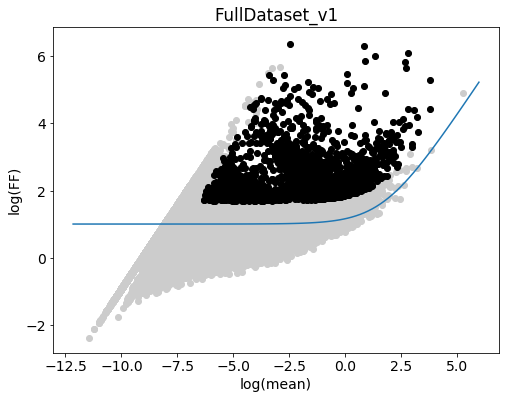

In [24]:
merge_setup = {'FullDataset_v1':sample_list}

for s, smerge in merge_setup.items():
    print smerge
    t0 = time.time()
    print t0
    print '________________', s
    
    cell_ix = np.in1d(samp_id_flat, smerge)
    
    run_all_spring_1_6(E[cell_ix,:],
                     list(merged_list), s, main_spring_dir, normalize=False, tot_counts_final = total_counts[cell_ix],
                     min_counts = 3, min_cells = 3, min_vscore_pctl = 85, 
                     show_vscore_plot = True, num_pc = 30, pca_method = '', k_neigh=4, use_approxnn = False,
                     #exclude_corr_genes_list=[g2m_genes], exclude_corr_genes_minCorr=0.2,
                     output_spring = True, num_force_iter = 2000,
                     cell_groupings = {'Sample': list(samp_id_flat[cell_ix])})
    
    print time.time() - t0
    
    np.save(main_spring_dir + s + '/cell_filter.npy', np.nonzero(cell_ix)[0])
    np.savetxt(main_spring_dir + s + '/cell_filter.txt', np.nonzero(cell_ix)[0], fmt='%i')
    
    print time.time() - t0


In [ ]:
!Rscript signac.R